# Sentiment Analysis
Sentiment Analysis involves determining the high level "tone" of a given piece of text. By using pre-trained Sentiment Classification Transformer models we can use a large amount of text data to determine the high level views around a specific topic! <br>
By extracting sentiment from online comments we can visualise the change in sentiment around a specific topic over time! <br>
One such use case is tracking the sentiment of comments around a specific publicly traded company. As the share price can also be thought of as a reflection of the "sentiment" around a company we should expect the comment sentiment to line up with the share price!

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

# from tqdm.notebook import trange, tqdm
from tqdm import tqdm, trange
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import copy
import numpy as np
from datetime import datetime
import os
import zipfile
import random

from transformers import BertForSequenceClassification, AutoTokenizer, pipeline, BertTokenizer

In [31]:
import torch
print(torch.cuda.device_count())  # Should return 1 or more if a GPU is available
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current device index

1
True
0


In [32]:
# We'll use a model that was specifically fine-tuned on online social media comments around finance!
model = BertForSequenceClassification.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment",
    num_labels=3,
    id2label={0: "neutral", 1: "positive", 2: "negative"},
    label2id={"neutral": 0, "positive": 1, "negative": 2},
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment"
)

# Construct a Huggingface pipeline!
sentiment_classifier = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=0, 
    top_k=None, padding=True, truncation=True, max_length=256
)

Device set to use cuda:0


## Create dataset and dataloader

In [33]:
class MyTextDataset(Dataset):
    def __init__(self, root_data_dir, stock_code):
        self.root_data_dir = root_data_dir
        self.stock_code = stock_code

        # Ensure the data is unzipped
        self.check_and_unzip()
        
        self.data_dir = os.path.join(self.root_data_dir, self.stock_code)
        
        # Get the list of files in the unzipped directory
        self.file_list = os.listdir(self.data_dir)
        self.num_samples = len(self.file_list)

    def check_and_unzip(self):
        # Specify the file name to search for
        zip_file_name = self.stock_code + ".zip"
        zip_path = os.path.join(self.root_data_dir, zip_file_name)
        extracted_dir = os.path.join(self.root_data_dir, self.stock_code)

        # Check if the extracted directory already exists
        if not os.path.exists(extracted_dir):
            # Check if the .zip file exists in the specified directory
            if os.path.exists(zip_path):
                # Unzip the file
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(self.root_data_dir)
                print(f"Extracted {zip_file_name} to {self.root_data_dir}")
            else:
                print(f"{zip_file_name} not found in {self.root_data_dir}")
        else:
            print(f"Directory {extracted_dir} already exists, skipping extraction.")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        with open(file_path, 'r', encoding='utf-8') as file:
            raw_data = file.read()
            
        text_data = raw_data.split(" : ")[-1]
        time_data = raw_data.split(" : ")[0]
            
        return text_data, time_data

In [34]:
# NOTE IF YOU ARE USING THE DATA FROM THE GITHUB REPO (nab.zip) YOU WILL NEED TO MANUALLY UNZIP IT FIRST
# TODO AUTO UNZIP
# Define the root directory of the dataset
stock_code = "nab"

# Example usage:
root_data_dir = ""
dataset = MyTextDataset(root_data_dir, stock_code)

loader = DataLoader(dataset, batch_size=32)

Directory nab already exists, skipping extraction.


In [35]:
text_data, time_data = dataset.__getitem__(100)

In [36]:
time_data

'2014-05-08T13:13:00+10:00'

In [37]:
text_data

'Originally posted by angelus512                                                        ↑\n\n\nAngelus,I think you are right about accumulation day.  AFR is quoting CMC dividend 4.18% return.  "Looking at the short term dividend ROI, NAB is likely to pick up the bulk of the dividend switching once ANZ begins trading ex div, CMC says."So on this logic Friday should see another rise in NAB share price as dividend hunters exit ANZ to hold NAB. Well it sounds reasonable but you never know what the agenda really is IMO.'

In [38]:
rand_indx = random.randint(0, len(dataset))
text_data, time_data = dataset.__getitem__(rand_indx)
with torch.cuda.amp.autocast():
        outputs = sentiment_classifier([text_data])

print(text_data)
print("\n")

print("This comment is rated %s with confidence %.3f" % (outputs[0][0]["label"], outputs[0][0]["score"]))

NAB SAYS NOW OFFERS HICAPS PRACTITIONERS ABILITY TO ACCEPT DIGITAL HEALTH INSURANCE MEMBERSHIP CARDS IN APPLE WALLET   ([email protected])


This comment is rated neutral with confidence 0.640


C:\Users\Amaan\AppData\Local\Temp\ipykernel_18900\1951555724.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [39]:
outputs

[[{'label': 'neutral', 'score': 0.640137255191803},
  {'label': 'positive', 'score': 0.35386279225349426},
  {'label': 'negative', 'score': 0.006000007502734661}]]

## Predict the sentiment from the comments!

In [40]:
log_positive_score = []
log_neutral_score = []
log_negative_score = []
log_datetime = []

for (input_data, time_data) in tqdm(loader):
    with torch.cuda.amp.autocast():
        outputs = sentiment_classifier(list(input_data), batch_size=len(input_data))

    for (output, td) in zip(outputs, time_data):
        for label in output:
            if label["label"] == 'positive':
                log_positive_score.append(label["score"])
            elif label["label"] == 'neutral':
                log_neutral_score.append(label["score"])
            elif label["label"] == 'negative':
                log_negative_score.append(label["score"])

        log_datetime.append(td)





  0%|          | 0/531 [00:00<?, ?it/s]C:\Users\Amaan\AppData\Local\Temp\ipykernel_18900\1958222553.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():




  0%|          | 1/531 [00:00<03:35,  2.46it/s]



  0%|          | 2/531 [00:00<02:04,  4.26it/s]



  1%|          | 3/531 [00:00<01:39,  5.29it/s]



  1%|          | 4/531 [00:00<01:28,  5.96it/s]



  1%|          | 5/531 [00:00<01:21,  6.46it/s]



  1%|          | 6/531 [00:01<01:11,  7.29it/s]



  1%|▏         | 7/531 [00:01<01:06,  7.90it/s]



  2%|▏         | 8/531 [00:01<01:12,  7.25it/s]



  2%|▏         | 9/531 [00:01<01:13,  7.06it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset




  2%|▏         | 10/531 [00:01<01:10,  7.34it/s]



  2%|▏         | 11/531 [00:01<01:13,  7.06it/s]



  2%|▏         | 12/531 [00:01<01:14,  6.99it/s]



  2%|

## Organise the Data!

In [41]:
# Create a panda dataframe
df = pd.DataFrame({
    'Datetime': log_datetime,
    'positive': log_positive_score,
    'neutral': log_neutral_score,
    'negative': log_negative_score,

})
# Set index to the date time
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)

# Sort all rows by the datetimeindex
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

In [50]:
df.head()

,positive,neutral,negative,score
Datetime,,,,
2002-04-23 00:55:00+00:00,0.425005,0.139061,0.435934,-0.012695
2002-04-23 01:45:00+00:00,0.189496,0.593459,0.217046,-0.067767
2002-04-23 02:06:00+00:00,0.946878,0.004376,0.048746,0.902080
2002-04-23 04:40:00+00:00,0.784648,0.027405,0.187947,0.613515
2002-04-23 04:44:00+00:00,0.410082,0.327465,0.262452,0.219513


## Calculate a Sentiment Score

In [42]:
# Calculate a 'score' using the positive and negative predictions
df['score'] = (df['positive'] - df['negative'])/(df['positive'] + df['negative'])

# Calculate median sentiment for everyday
df_daily = df.resample('D').median()
df_daily.fillna(0, inplace=True)

# Count the number of entries per day
df_daily_count = df.resample('D').size()

# If you want to add this count to your existing df_daily DataFrame:
df_daily['entry_count'] = df_daily_count
df_daily['entry_count_ma'] = df_daily['entry_count'].rolling(window=28, center=False).mean()

# Calculate a 28 day moving average of the score
df_daily['score_ma'] = df_daily['score'].rolling(window=28, center=False).mean()

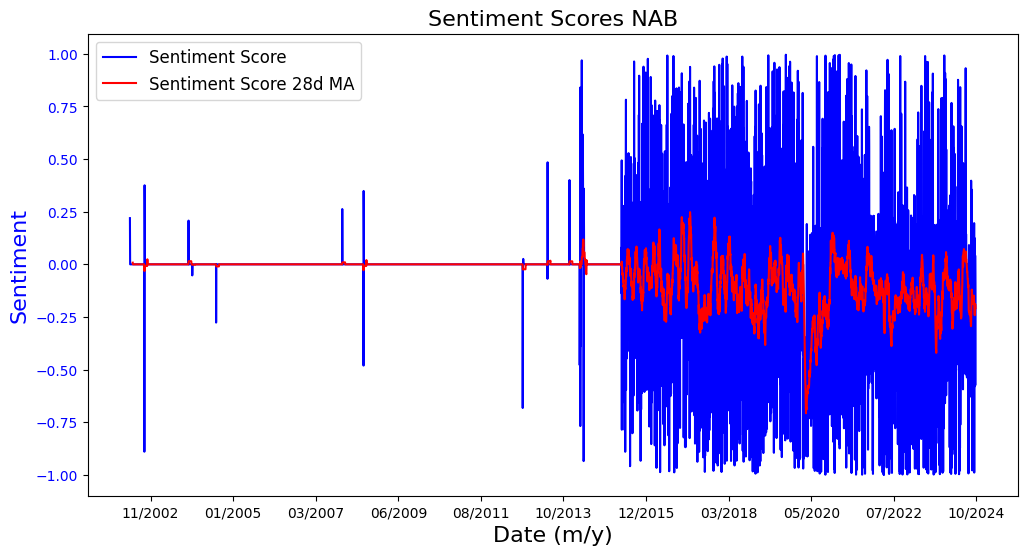

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_daily.index, 
         df_daily['score'], color='blue', label='Sentiment Score')

ax1.plot(df_daily.index, 
         df_daily['score_ma'], color='red', label='Sentiment Score 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment Scores ' + stock_code.upper(), fontsize=16)

## Get the Stock Price to Compare

In [44]:
# Download the stock price data to compare
msft = yf.Ticker(stock_code + ".ax")
stock_data = msft.history(period = "9y", interval = "1d")
stock_data.drop('Dividends', axis=1, inplace=True)
stock_data.drop('Stock Splits', axis=1, inplace=True)

# Get a price for every day (including weekends etc)
stock_data = stock_data.resample('D').mean()

# Fill forward price data (carry the price data forward for weekends etc)
stock_data.fillna(method='ffill', inplace=True)

# Get a 28 day and 120 day moving average of the close price
stock_data['close_ma'] = stock_data['Close'].rolling(window=28, center=False).mean()
stock_data['close_120_ma'] = stock_data['Close'].rolling(window=120, center=False).mean()
stock_data.dropna(inplace=True)

# Calculate the short term price movements by subtracting the 120 day MA
stock_data['close_diff'] = stock_data['Close'] - stock_data['close_120_ma']

C:\Users\Amaan\AppData\Local\Temp\ipykernel_18900\2080687650.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [45]:
# Cut the sentiment data to match the same time period as the stock price data
specific_date = stock_data.index[0]

# Filter the DataFrame to get data after the specific date
df_after_specific_date = df_daily.loc[specific_date:]

## Plot the results!

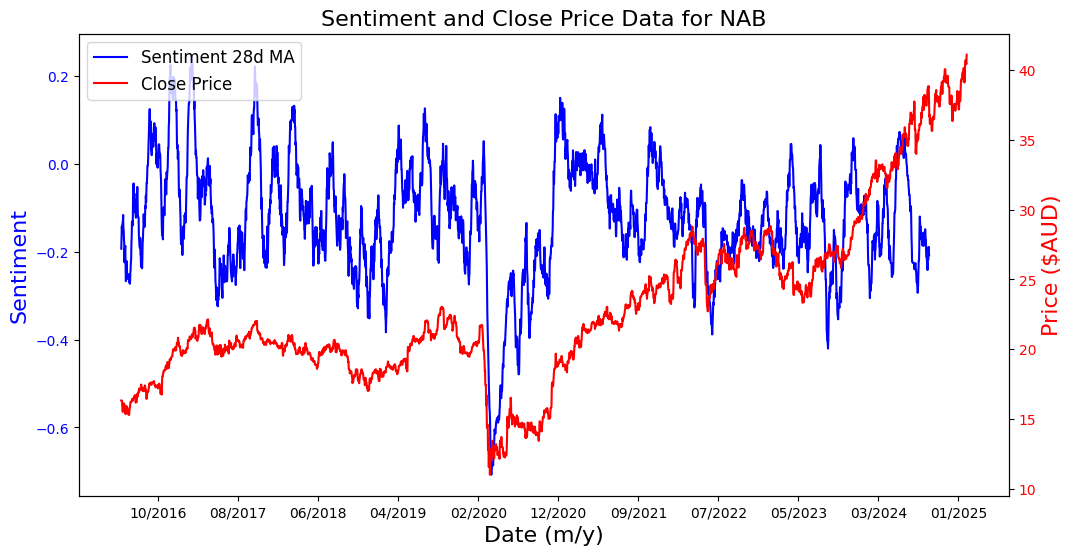

In [46]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['Close'], 
         color='red', label='Close Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Close Price Data for ' + stock_code.upper(), fontsize=16)

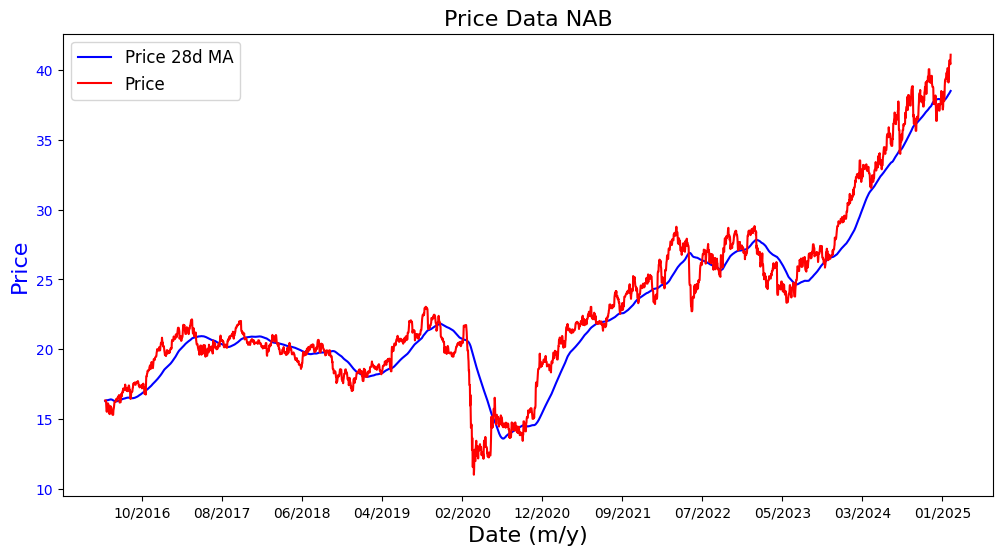

In [47]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(stock_data.index, 
         stock_data['close_120_ma'], color='blue', label='Price 28d MA')

ax1.plot(stock_data.index, 
         stock_data['Close'], color='red', label='Price')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Price Data ' + stock_code.upper(), fontsize=16)

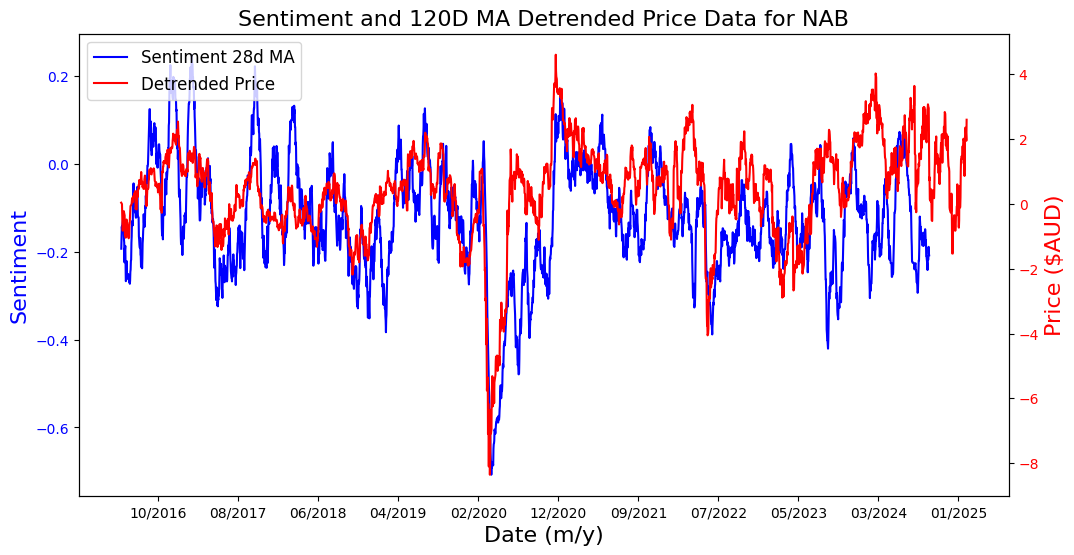

In [48]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['close_diff'], 
         color='red', label='Detrended Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and 120D MA Detrended Price Data for ' + stock_code.upper(), fontsize=16)

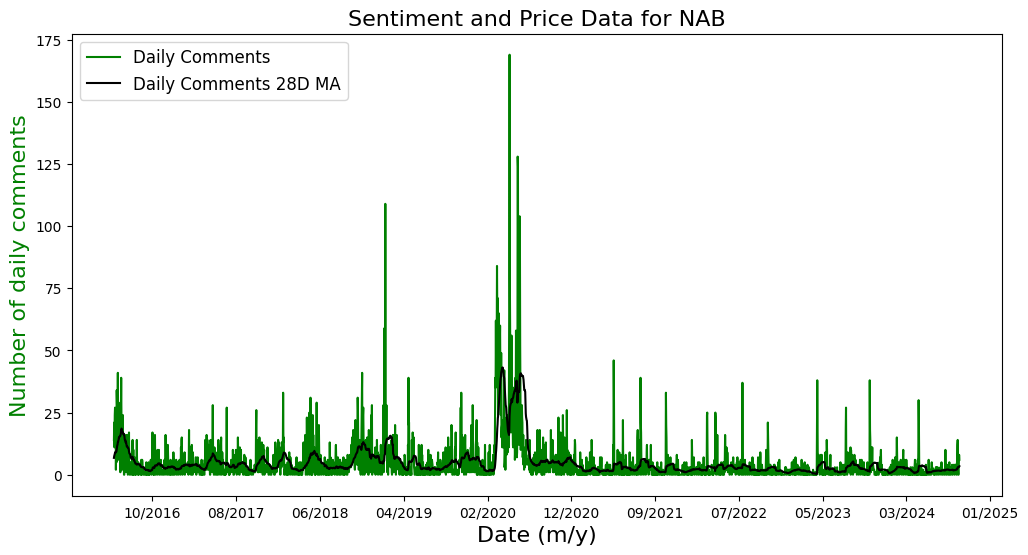

In [49]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count'], color='green', label='Daily Comments')

ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count_ma'], color='k', label='Daily Comments 28D MA')

ax1.set_ylabel('Number of daily comments', color='green', fontsize=16)
ax1.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Add legend
ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Price Data for ' + stock_code.upper(), fontsize=16)